This notebook analyzes B cells from single-cell RNA-seq data, comparing gene expression between two conditions: aHD (likely healthy donors) and aSLE (Systemic Lupus Erythematosus patients). The analysis uses the scanpy package for preprocessing and visualization, and custom Python functions for filtering genes.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ot
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scanpy as sc
import anndata as ad

import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
data = sc.read_h5ad('./data/preprocessed_adata.h5ad')

Filtering the dataset to keep only B cells based on the annotation column level1_anno.

In [ ]:
B_cells = data[data.obs['level1_anno'] == 'B']

Performing PCA and plotting the cells colored by experimental group (e.g., aHD vs aSLE) to visualize transcriptional variation

/Users/suhuidong/anaconda3/envs/OT_testing/lib/python3.11/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


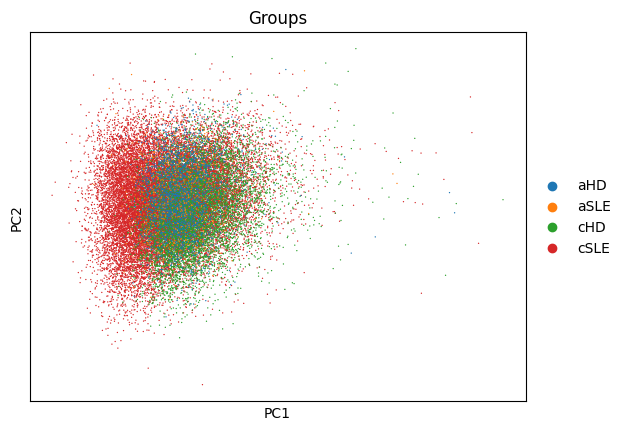

In [ ]:
sc.pl.pca(B_cells, color='Groups')

In [80]:
sc.pp.filter_cells(B_cells, min_genes=10)
sc.pp.filter_genes(B_cells, min_cells=3)

Lets check how many cells (n_obs) and genes (n_vars) remain after filtering. Also see metadata in .obs.

In [81]:
B_cells

AnnData object with n_obs × n_vars = 32467 × 18957
    obs: 'cell_id', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id', 'batch_id', 'leiden', 'predicted_labels', 'leiden_1', 'leiden_1.5', 'leiden_1.8', 'leiden_2', 'level1_anno', 'Names', 'Groups', 'Batch', 'Age', 'Gender', 'Race', 'Ethnicity', 'SLEDAI', 'Physician Notes', 'Collection_year', 'Symptoms', 'MDG', 'Arthritis', 'Rash', 'Proteinuria', 'Hematuria', 'Urinary Casts', 'Pyuria', 'dsDNA', 'low_com', 'fever', 'pleurisy', 'vasculitis', 'Alopecia', 'Leukopenia', 'MMF', 'OS', 'MTX', 'Plaquenil', 'Neph_all', 'Proliferative_Neph', 'Memb_Neph', 'Nephrology_Class', 'Neph_class', 'ESR', 'WBC', 'RBC', 'MONOCYTE_per', 'NEUTROPHIL_per', 'LYMPHOCYTE_per', 'HGB', 'HCT', 'PLATELETS', 'NEU_ABS', 'LYM_ABS', 'CREATININE', 'ALBUMIN', 'DSDNA_ratio', 'DSDNA', 'C3', 'C4', 'ALT', 'AST', 'ALD', 'LDH', 'MSK', 'KIDNEY', 'SERUM', 'Groups_numeric', 'n_genes'
    var: 'variances_CD8_T',

In [ ]:


def filter_genes_expressed_in_both_groups(
    adata: ad.AnnData,
    group_column: str,
    group1: str,
    group2: str,
    threshold: int = 5
) -> ad.AnnData:
    """
    Filters genes in an AnnData object to keep only those expressed in both specified groups.

    Parameters:
    - adata (AnnData): The input AnnData object.
    - group_column (str): Column name in `.obs` that contains group labels.
    - group1 (str): Name of the first group (e.g., 'aHD').
    - group2 (str): Name of the second group (e.g., 'aSLE').
    - threshold (int): Minimum number of cells a gene must be expressed in (>0) to be considered expressed.

    Returns:
    - AnnData: A new AnnData object filtered to keep only genes expressed in both groups.
    """
    # Create masks for each group
    group1_mask = np.sum(adata[adata.obs[group_column] == group1].X > 0, axis=0) > threshold
    group2_mask = np.sum(adata[adata.obs[group_column] == group2].X > 0, axis=0) > threshold

    # Find genes expressed in both groups
    expressed_in_both = np.array(group1_mask).ravel() & np.array(group2_mask).ravel()

    # Return filtered AnnData object
    return adata[:, expressed_in_both].copy()

Keeping only genes that are expressed in at least 5 cells in both groups (aHD, aSLE), ensuring fair comparisons.

In [83]:
B_cells_filtered = filter_genes_expressed_in_both_groups(
    adata=B_cells,
    group_column='Groups',
    group1='aHD',
    group2='aSLE',
    threshold=5
)

In [ ]:
def extract_group_expression(
    adata: ad.AnnData,
    group_column: str,
    group_labels: list
) -> pd.DataFrame:
    """
    Extracts gene expression data for specified groups and returns a DataFrame.

    Parameters:
    - adata (AnnData): Filtered AnnData object.
    - group_column (str): Column in `.obs` that contains group labels.
    - group_labels (list): List of group names to include (e.g., ['cHD', 'aHD']).

    Returns:
    - pd.DataFrame: Gene expression matrix with genes as columns.
    """
    group_data = adata[adata.obs[group_column].isin(group_labels)]
    genes = adata.var_names

    # Convert sparse matrix to dense if needed
    if hasattr(group_data.X, "toarray"):
        expression = group_data.X.toarray()
    else:
        expression = group_data.X

    return pd.DataFrame(expression, columns=genes)

In [85]:
from sklearn.decomposition import PCA

def perform_pca(
    expression_df: pd.DataFrame,
    n_components: int = 15
) -> np.ndarray:
    """
    Performs PCA on the expression DataFrame.

    Parameters:
    - expression_df (pd.DataFrame): Gene expression matrix.
    - n_components (int): Number of PCA components to compute.

    Returns:
    - np.ndarray: Transformed PCA components.
    """
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(expression_df)
    return pcs

In [86]:
# Extract gene expression for HD and SLE groups
df_hd = extract_group_expression(B_cells_filtered, group_column='Groups', group_labels=['cHD', 'aHD'])
df_sle = extract_group_expression(B_cells_filtered, group_column='Groups', group_labels=['cSLE', 'aSLE'])

# Perform PCA
pca_hd = perform_pca(df_hd, n_components=15)
pca_sle = perform_pca(df_sle, n_components=15)

In [ ]:
from scipy.stats import gaussian_kde

def fit_kde(pcs: np.ndarray, bw_method: str = 'scott') -> gaussian_kde:
    """
    Fits a Gaussian KDE to the input principal components.

    Parameters:
    - pcs (np.ndarray): PCA-transformed data (rows = samples, cols = components).
    - bw_method (str): Bandwidth estimation method (default: 'scott').

    Returns:
    - gaussian_kde: Fitted KDE object.
    """
    return gaussian_kde(pcs.T, bw_method=bw_method)

In [88]:
def evaluate_density(kde_model: gaussian_kde, pcs: np.ndarray) -> np.ndarray:
    """
    Evaluates density values for the input PCA data using a fitted KDE model.

    Parameters:
    - kde_model (gaussian_kde): Fitted KDE model.
    - pcs (np.ndarray): PCA-transformed data.

    Returns:
    - np.ndarray: Density estimates.
    """
    return kde_model(pcs.T)

In [89]:
def normalize_density(density: np.ndarray) -> np.ndarray:
    """
    Normalizes a density array using min-max scaling to [0, 1].

    Parameters:
    - density (np.ndarray): Raw density values.

    Returns:
    - np.ndarray: Normalized density values (between 0 and 1).
    """
    min_val = np.min(density)
    max_val = np.max(density)
    if max_val - min_val == 0:
        return np.zeros_like(density)
    return (density - min_val) / (max_val - min_val)

In [90]:
# Fit KDEs
kde_hd = fit_kde(pca_hd)
kde_sle = fit_kde(pca_sle)

# Evaluate densities
density_hd = evaluate_density(kde_hd, pca_hd)
density_sle = evaluate_density(kde_sle, pca_sle)

# Normalize
mu = normalize_density(density_hd)
nu = normalize_density(density_sle)

In [ ]:
def compute_cost_matrix(
    X1: np.ndarray,
    X2: np.ndarray,
    metric: str = 'euclidean'
) -> np.ndarray:
    """
    Computes the cost matrix (pairwise distances) between two sets of samples.

    Parameters:
    - X1 (np.ndarray): Samples from group 1 (shape: [n_samples_1, n_features]).
    - X2 (np.ndarray): Samples from group 2 (shape: [n_samples_2, n_features]).
    - metric (str): Distance metric to use (default: 'euclidean').

    Returns:
    - np.ndarray: Cost matrix of shape [n_samples_1, n_samples_2].
    """
    return ot.dist(X1, X2, metric=metric)

In [92]:
def normalize_cost_matrix(cost_matrix: np.ndarray) -> np.ndarray:
    """
    Normalizes a cost matrix using min-max scaling to [0, 1].

    Parameters:
    - cost_matrix (np.ndarray): Raw cost matrix.

    Returns:
    - np.ndarray: Normalized cost matrix.
    """
    min_val = np.min(cost_matrix)
    max_val = np.max(cost_matrix)
    if max_val - min_val == 0:
        return np.zeros_like(cost_matrix)
    return (cost_matrix - min_val) / (max_val - min_val)

In [93]:
# Compute and normalize cost matrix
cost_matrix = compute_cost_matrix(df_hd.values, df_sle.values, metric='euclidean')
cost_matrix_norm = normalize_cost_matrix(cost_matrix)

In [ ]:
def compute_transport_plan(
    mu: np.ndarray,
    nu: np.ndarray,
    cost_matrix: np.ndarray,
    reg: float = 1.0
) -> np.ndarray:
    """
    Computes the optimal transport plan using the Sinkhorn algorithm.

    Parameters:
    - mu (np.ndarray): Source distribution (must sum to 1).
    - nu (np.ndarray): Target distribution (must sum to 1).
    - cost_matrix (np.ndarray): Normalized cost matrix (shape: [n, m]).
    - reg (float): Regularization parameter (lambda).

    Returns:
    - np.ndarray: Optimal transport plan (same shape as cost_matrix).
    """

    # Run Sinkhorn algorithm
    transport_plan = ot.sinkhorn(mu, nu, cost_matrix, reg)
    return transport_plan

In [95]:
lambda_reg = 10
transport_plan = compute_transport_plan(mu, nu, cost_matrix_norm, reg=lambda_reg)

/Users/suhuidong/anaconda3/envs/OT_testing/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:624: RuntimeWarning: divide by zero encountered in divide
  Kp = (1 / a).reshape(-1, 1) * K
/Users/suhuidong/anaconda3/envs/OT_testing/lib/python3.11/site-packages/ot/bregman/_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


In [ ]:
def compute_expression_difference(
    transport_plan: np.ndarray,
    source_expression: np.ndarray,
    target_expression: np.ndarray
) -> np.ndarray:
    """
    Computes gene expression differences between original and transported profiles.

    Parameters:
    - transport_plan (np.ndarray): Optimal transport plan (shape: [n_source, n_target]).
    - source_expression (np.ndarray): Expression matrix for source group (Group 0), shape [n_source, n_genes].
    - target_expression (np.ndarray): Expression matrix for target group (Group 1), shape [n_target, n_genes].

    Returns:
    - np.ndarray: Expression difference matrix, shape [n_source, n_genes].
    """
    # Normalize transport plan row-wise
    row_sums = transport_plan.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    transport_plan_normalized = transport_plan / row_sums

    # Compute transported expression profiles
    transported_expr = np.dot(transport_plan_normalized, target_expression)

    # Compute expression difference
    expr_difference = transported_expr - source_expression

    return expr_difference

In [99]:
expr_difference = compute_expression_difference(
    transport_plan=transport_plan,
    source_expression=df_hd.values,
    target_expression=df_sle.values
)

In [ ]:
def compute_standard_error(
    expr_diff: np.ndarray,
    ddof: int = 1
) -> np.ndarray:
    """
    Computes the standard error of expression differences for each gene.

    Parameters:
    - expr_diff (np.ndarray): Expression difference matrix [n_cells, n_genes].
    - ddof (int): Delta degrees of freedom for std calculation (default = 1).

    Returns:
    - np.ndarray: Adjusted standard error for each gene (shape: [n_genes]).
    """
    n_cells = expr_diff.shape[0]
    
    # Compute standard deviation across cells (per gene)
    std_diff = np.std(expr_diff, axis=0, ddof=ddof)
    
    # Compute standard error
    se_diff = std_diff / np.sqrt(n_cells)
    
    # Adjust to avoid division by zero
    se_diff_adj = np.where(se_diff == 0, np.finfo(float).eps, se_diff)

    return se_diff_adj

In [101]:
se_expr_diff_adj = compute_standard_error(expr_difference)

In [ ]:
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

def perform_wald_test(
    expr_diff: np.ndarray,
    se_diff_adj: np.ndarray
) -> dict:
    """
    Performs Wald test on gene expression differences and applies FDR correction.

    Parameters:
    - expr_diff (np.ndarray): Expression difference matrix [n_cells, n_genes].
    - se_diff_adj (np.ndarray): Adjusted standard errors [n_genes].

    Returns:
    - dict: Dictionary with keys:
        - 'mean_diff': Mean expression difference per gene
        - 'wald_stat': Wald statistics per gene
        - 'p_values': Two-tailed p-values
        - 'adj_p_values': FDR-adjusted p-values (Benjamini-Hochberg)
    """
    # Compute mean difference
    mean_diff = np.mean(expr_diff, axis=0)

    # Compute Wald statistics
    wald_stat = mean_diff / se_diff_adj

    # Compute two-tailed p-values
    p_values = 2 * norm.sf(np.abs(wald_stat))

    # Adjust p-values using Benjamini-Hochberg FDR
    _, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    return {
        "mean_diff": mean_diff,
        "wald_stat": wald_stat,
        "p_values": p_values,
        "adj_p_values": adj_p_values
    }

In [104]:
results = perform_wald_test(expr_difference, se_expr_diff_adj)

In [105]:
# Create the DE results DataFrame
de_results = pd.DataFrame({
    'Gene': B_cells_filtered.var_names,
    'Average_Expression_Diff': results["mean_diff"],
    'Adj_SE': se_expr_diff_adj,
    'Wald_Statistic': results["wald_stat"],
    'PValue': results["p_values"],
    'AdjPValue': results["adj_p_values"]
})

# Sort the DataFrame by adjusted p-value
de_results.sort_values('AdjPValue', ascending=True, inplace=True)

# Display the top DE genes
print(de_results.head(20))

               Gene  Average_Expression_Diff    Adj_SE  Wald_Statistic  \
2507          RPL34                -0.117902  0.002508      -47.017982   
635          S100A8                 0.296457  0.003111       95.296219   
633          S100A9                 0.343169  0.003592       95.535240   
4141           SAT1                 0.208867  0.005290       39.487167   
3840         SAMD9L                 0.104532  0.002043       51.156364   
9280         RPL18A                -0.110035  0.002594      -42.411236   
10029          TYMP                 0.145209  0.002536       57.256645   
4393          RPL10                -0.144693  0.002589      -55.879425   
10031  CTA-384D8.34                 0.032481  0.000366       88.694405   
7546           RPS2                -0.103422  0.002732      -37.853569   
1142        EIF2AK2                 0.139939  0.002021       69.255310   
6723         EPSTI1                 0.376702  0.002655      141.904297   
8529       LGALS3BP                 0.

In [106]:
# Define the significance threshold
significance_threshold = 0.05/10150

# Identify significant genes
significant_genes = de_results[de_results['PValue'] < significance_threshold]
num_significant_genes = significant_genes.shape[0]

print(f'Number of significantly differentially expressed genes (P-Value < {significance_threshold}): {num_significant_genes}')

Number of significantly differentially expressed genes (P-Value < 4.926108374384236e-06): 2319


In [ ]:
def plot_pvalue_histogram(
    p_values: np.ndarray,
    bins: int = 50,
    title: str = "Histogram of P-Values under Null Hypothesis",
    figsize: tuple = (8, 6),
    color: str = 'skyblue'
):
    """
    Plots a histogram of p-values.

    Parameters:
    - p_values (np.ndarray): Array of p-values.
    - bins (int): Number of bins in the histogram (default: 50).
    - title (str): Plot title.
    - figsize (tuple): Size of the figure.
    - color (str): Bar color for the histogram.
    """
    plt.figure(figsize=figsize)
    plt.hist(p_values, bins=bins, color=color, edgecolor='black')
    plt.xlabel('P-Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

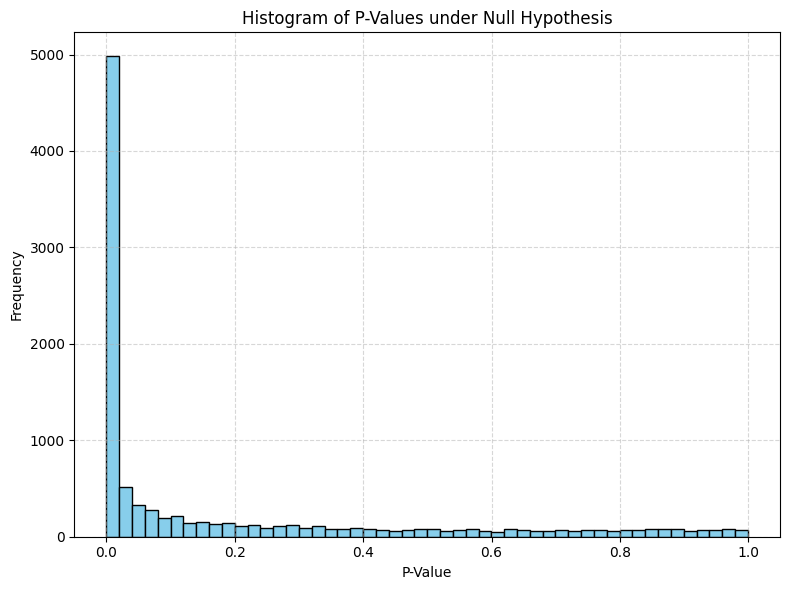

In [108]:
plot_pvalue_histogram(p_values)

In [ ]:
def plot_gene_density_comparison(
    df_hd: pd.DataFrame,
    df_sle: pd.DataFrame,
    genes,
    group_labels: tuple = ("HD", "SLE"),
    figsize: tuple = (10, 6)
):
    """
    Plots KDE for one or more genes in both HD and SLE groups.

    Parameters:
    - df_hd (pd.DataFrame): Expression data for HD group.
    - df_sle (pd.DataFrame): Expression data for SLE group.
    - genes (str or list): One gene or list of genes to plot.
    - group_labels (tuple): Labels for the HD and SLE groups.
    - figsize (tuple): Size of each subplot.
    """
    if isinstance(genes, str):
        genes = [genes]  # Wrap single gene name in a list

    for gene in genes:
        if gene not in df_hd.columns or gene not in df_sle.columns:
            raise ValueError(f"Gene '{gene}' not found in one of the DataFrames.")

        plt.figure(figsize=figsize)
        sns.kdeplot(df_hd[gene], fill=True, label=group_labels[0], color='skyblue', linewidth=2)
        sns.kdeplot(df_sle[gene], fill=True, label=group_labels[1], color='salmon', linewidth=2)

        plt.xlabel('Expression Level')
        plt.ylabel('Density')
        plt.title(f"Density Comparison for Gene: {gene}")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

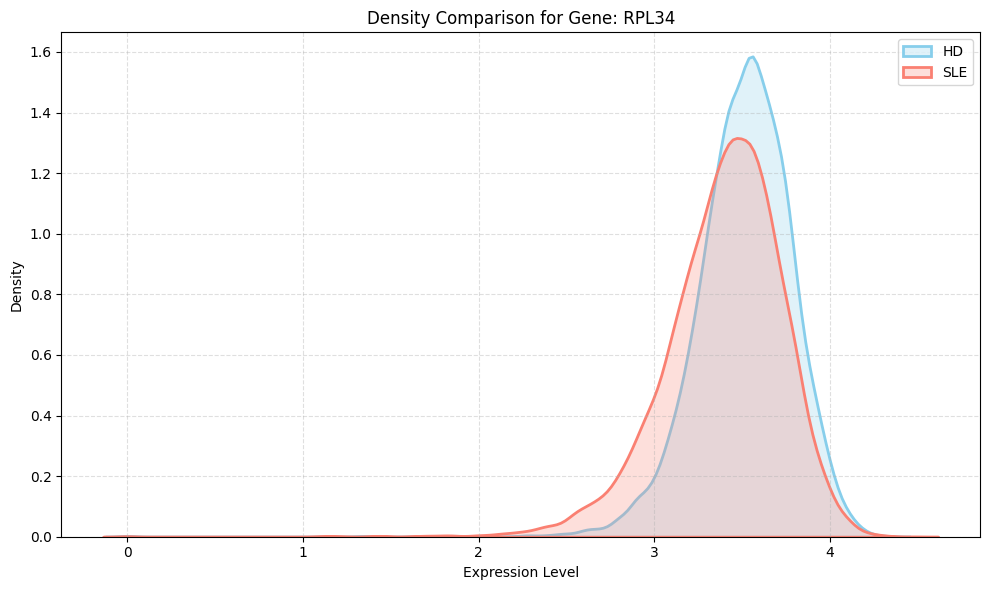

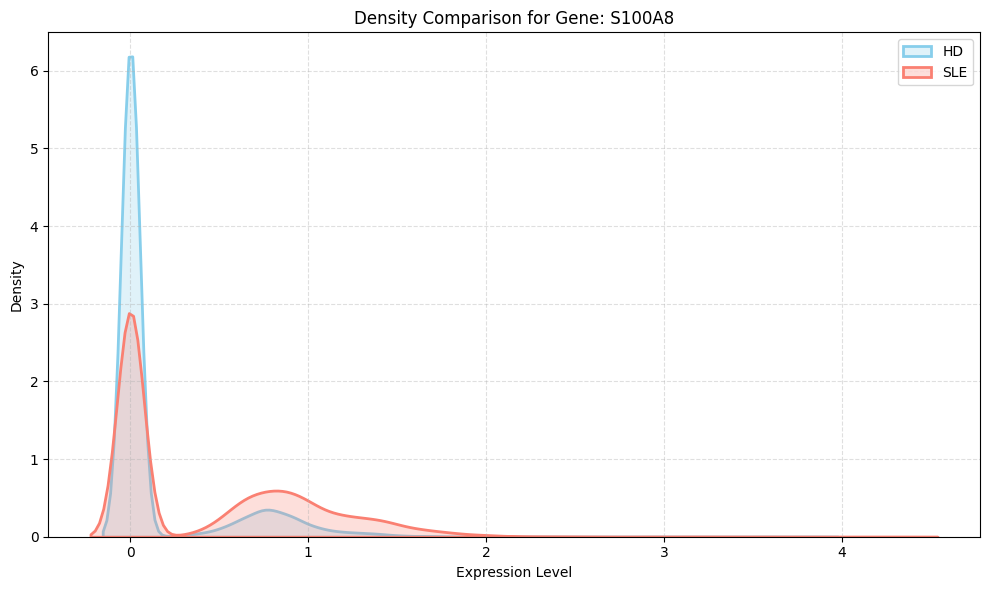

In [110]:
plot_gene_density_comparison(df_hd, df_sle, genes=['RPL34', 'S100A8'])

In [ ]:
def plot_gene_violin_comparison(
    df_hd: pd.DataFrame,
    df_sle: pd.DataFrame,
    genes,
    group_labels: tuple = ("HD", "SLE"),
    figsize: tuple = (8, 6)
):
    """
    Plots violin plots for one or more genes comparing HD vs SLE.

    Parameters:
    - df_hd (pd.DataFrame): Expression data for HD group.
    - df_sle (pd.DataFrame): Expression data for SLE group.
    - genes (str or list): One gene or list of genes to plot.
    - group_labels (tuple): Labels for HD and SLE groups.
    - figsize (tuple): Size of each individual figure.
    """
    if isinstance(genes, str):
        genes = [genes]

    for gene in genes:
        if gene not in df_hd.columns or gene not in df_sle.columns:
            raise ValueError(f"Gene '{gene}' not found in one of the DataFrames.")

        # Combine data
        df_plot = pd.DataFrame({
            "Expression": pd.concat([df_hd[gene], df_sle[gene]]),
            "Group": [group_labels[0]] * len(df_hd) + [group_labels[1]] * len(df_sle)
        })

        plt.figure(figsize=figsize)
        sns.violinplot(data=df_plot, x="Group", y="Expression", palette=["skyblue", "salmon"])
        plt.title(f"Violin Plot of {gene} Expression")
        plt.xlabel("Group")
        plt.ylabel("Expression Level")
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

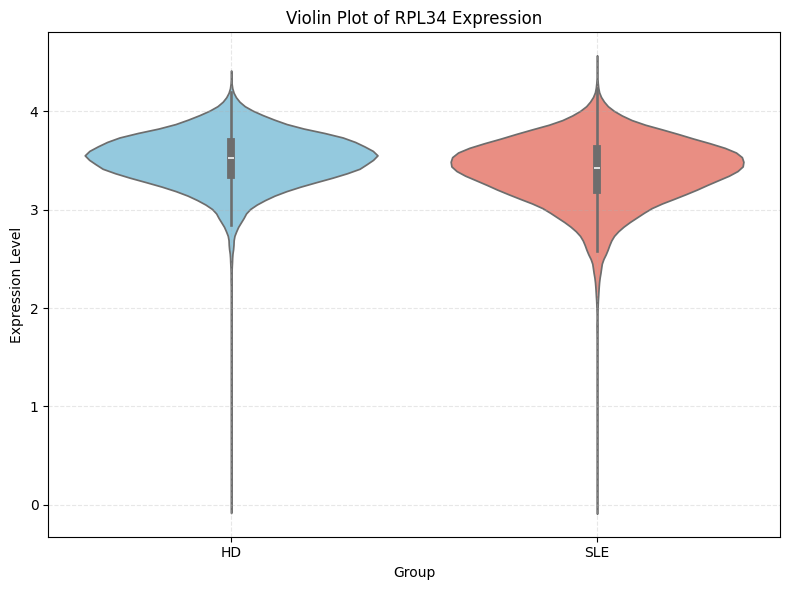

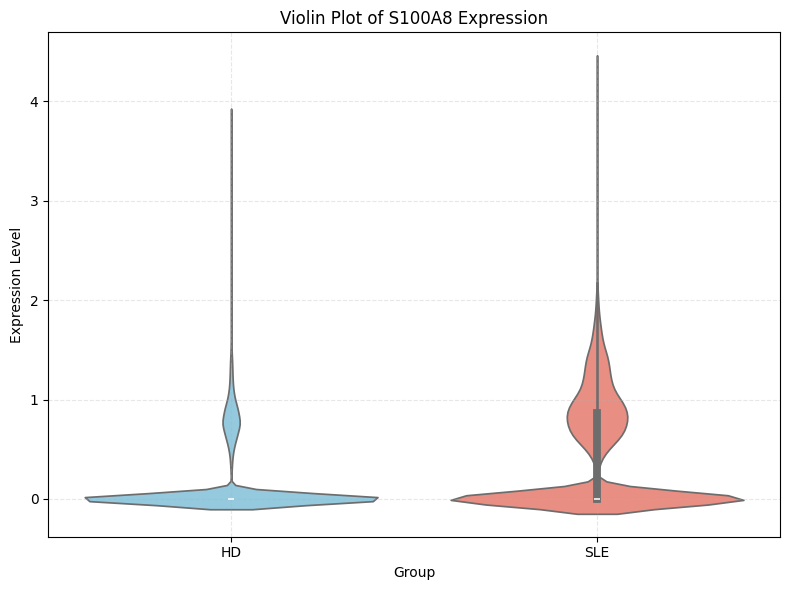

In [112]:
plot_gene_violin_comparison(df_hd, df_sle, genes=['RPL34', 'S100A8'])

In [ ]:
def plot_volcano_comparison(
    de_results_list,
    method_names,
    fc_col='Average_Expression_Diff',
    pval_col='AdjPValue',
    gene_count=10150,
    significance_level=0.05,
    figsize=(8, 7),
    titles=None
):
    """
    Plots multiple volcano plots side-by-side for differential expression results.

    Parameters:
    - de_results_list: List of DataFrames, each with fold change and adjusted p-value columns.
    - method_names: List of method names (used in legends and titles).
    - fc_col: Name of the column with fold change or avg expression difference.
    - pval_col: Name of the column with adjusted p-values.
    - gene_count: Total number of genes (used for Bonferroni correction).
    - significance_level: Base significance threshold (e.g., 0.05).
    - figsize: Tuple for figure size.
    - titles: List of titles for each subplot (optional).
    """
    num_methods = len(de_results_list)
    y_line = -np.log10(significance_level / gene_count)

    fig, axs = plt.subplots(1, num_methods, figsize=figsize, sharey=True)

    if num_methods == 1:
        axs = [axs]  # Ensure axs is always iterable

    for i, (df, method) in enumerate(zip(de_results_list, method_names)):
        ax = axs[i]
        ax.scatter(
            df[fc_col],
            -np.log10(df[pval_col]),
            alpha=0.3,
            label=method,
            color='steelblue'
        )
        ax.axhline(y=y_line, color='red', linestyle='--', linewidth=1)
        ax.set_xlabel('Average Expression Difference')
        if i == 0:
            ax.set_ylabel('-log10(Adjusted P-Value)')
        if titles:
            ax.set_title(titles[i])
        else:
            ax.set_title(f"{method} Method")
        ax.legend()

    plt.tight_layout()
    plt.show()

/Users/suhuidong/anaconda3/envs/OT_testing/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


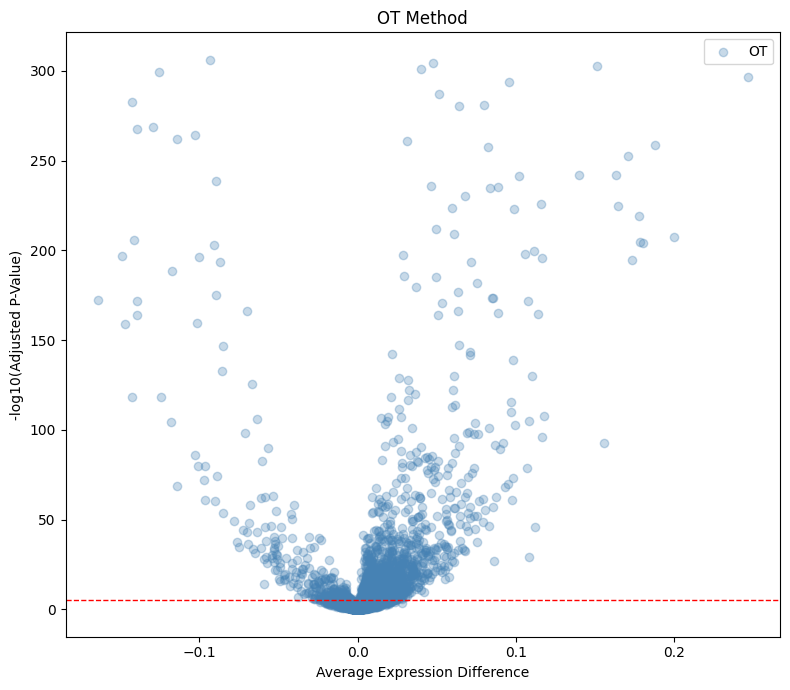

In [114]:
plot_volcano_comparison(
    de_results_list=[de_results],
    method_names=['OT'],
    gene_count=10150  # or your actual gene count
)